#  Covid test data for Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum

Additionally, daily case data at MSOA level is available that was downloaded at a previous date (?). This data does not include dates, but instead day numbers starting from 0. Day 0 is believed to equate to the 1st April 2020.  

### Script functionality
This script compares the weekly case data from the government website, with the daily case data (previously downloaded from government website?).  
Plots cases over time for both the whole of Devon and for individual MSOAs.  


### Conclusions
'Daily data' wasn't actually raw case data as thought, but created by Hadren in script at https://github.com/Urban-Analytics/RAMP-UA/blob/Ecotwins-withCommuting/lab/createSeedingFiles.R

In [115]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
import matplotlib.dates as mdates
import numpy as np  

# Case data - individual MSOAs
## Weekly case data
### Download COVID test data for the UK from government website

In [116]:
# define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
df = pd.read_csv(new_url)

# And filter to time period
start, end = "2020-04-01", "2020-12-12"
query_string = 'date >= "{}" & date <= "{}"'.format(start, end)
df = df.query(query_string)

### Reformat date and keep only data for MSOAs in Devon

In [117]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

weekly_cases_msoas.head()


,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004129,2020-05-01,3
E02004129,2020-10-30,4
E02004129,2020-11-06,4
E02004129,2020-11-13,7
E02004129,2020-11-20,8


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [118]:
# Create dataframe containing the dates for which there are data in at least one MSOA
dates = pd.DataFrame({'Date':weekly_cases_msoas['Date'].unique()})
# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)
weekly_cases_msoas

,Date,E02004129,E02004130,E02004131,E02004132,E02004133,E02004134,E02004135,E02004136,E02004137,...,E02004226,E02004227,E02004228,E02004229,E02004230,E02004231,E02004232,E02004233,E02004234,E02004235
16,2020-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
17,2020-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2020-04-17,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,16.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
18,2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN
0,2020-05-01,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN
12,2020-05-08,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2020-05-29,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2020-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Daily case data 

### Read in daily case data

In [119]:
# Observed cases data
# These were prepared by Hadrien and made available on the RAMP blob storage (see the observation data README).
daily_cases_msoas = pd.read_csv("england_initial_cases_MSOAs.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

### Keep only data for Devon

In [120]:
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only cases for MSOA codes in Devon
daily_cases_msoas = daily_cases_msoas.join(other=devon_msoa_codes, how="inner")  # Joins on the indices (both indices are MSOA code)
assert len(daily_cases_msoas) == len(devon_msoa_codes)  # Check we don't use any areas in the join
daily_cases_msoas.head()

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D395,D396,D397,D398,D399,D400,D401,D402,D403,D404
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02004129,0,0,0,0,0,0,0,0,0,0,...,21,0,0,0,0,0,0,0,0,0
E02004130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E02004131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E02004132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E02004133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Convert format
Previous format: MSOA codes as index, column for each day containing case numbers on each day for each MSOA  
New format: One column with day number, column for each MSOA containing cases numbers on each day

Create a date column from day column (assuming day 1 is the 1st April 2020)

In [121]:
# Containing cases
daily_cases_msoas = daily_cases_msoas.iloc[:, 0:405]
#cases_msoas_devon_t.reset_index(level=0, inplace=True)
# Change to MSOA as columns, days as rows
daily_cases_msoas = daily_cases_msoas.T

# set MSOA codes as column names and remove as a row
#cases_msoas_devon_t.rename(columns=cases_msoas_devon_t.iloc[0], inplace=True)
#cases_msoas_devon.drop(cases_msoas_devon.index[0], inplace=True)

# # Add column with Day number at front of columns
daily_cases_msoas.insert(0, 'Day', range(0, len(daily_cases_msoas)))
daily_cases_msoas

###### Add a column containing the date, assume day 0 is first of April
# Define base date as 1st of April
base = datetime.date(year=2020, month=4, day=1)
# Count number of days dataframe covers
numdays = len(daily_cases_msoas)
# Create a list of this number of days starting from the base date
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
# Add date column
daily_cases_msoas.insert(1, 'Date', [base + datetime.timedelta(days=x) for x in range(numdays)])
# Remove day columns
daily_cases_msoas =daily_cases_msoas.drop('Day',axis = 1)

daily_cases_msoas.to_csv("daily_cases_msoas.csv", index = False)


### Create dataframe containing cumulative case numbers on each day

In [122]:
# # Create new dataframe with cumulative sums rather than cases per day
# daily_cumcases_msoas = daily_cases_msoas.copy()
# for colname in daily_cumcases_msoas.columns[1:].tolist():
#     daily_cumcases_msoas[colname] = daily_cumcases_msoas[colname].cumsum()

# #cumcases_msoas_devon_t.to_csv("observations_df_t.csv", index = False)    

## Daily case data - summed to weekly

Start on same days as used in the weekly data

In [123]:
# First date for which we can get a full 7 days before hand is "2020-04-09"
# 7 days before this is 2020-04-03
# So delete data from before this
daily_cases_msoas = daily_cases_msoas[2:] 
# Drop day number from index and remove the title
daily_cases_msoas.reset_index(drop=True, inplace = True)
daily_cases_msoas = daily_cases_msoas.rename_axis(index=None, columns=None)

list_dfs = []
for msoa_code in daily_cases_msoas.columns[2:]:
    one_msoa = daily_cases_msoas[['Date', msoa_code] ]
    # define how to treat columns
    column_operations = {'Date': 'last', msoa_code: 'sum'}
    # 
    one_msoa = one_msoa.groupby(one_msoa.index // 7).agg(column_operations)
    #
    if not list_dfs:
        list_dfs.append(one_msoa)
    else:
        list_dfs.append(one_msoa[msoa_code])
    
daily_cases_msoas_weeklysums = pd.concat(list_dfs, axis=1)
daily_cases_msoas_weeklysums.head()

,Date,E02004130,E02004131,E02004132,E02004133,E02004134,E02004135,E02004136,E02004137,E02004138,...,E02004226,E02004227,E02004228,E02004229,E02004230,E02004231,E02004232,E02004233,E02004234,E02004235
0,2020-04-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-04-16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-04-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-04-30,0,0,0,112,0,0,0,0,85,...,0,0,0,0,0,0,0,112,0,0
4,2020-05-07,0,0,0,56,0,0,0,0,41,...,0,0,0,0,0,0,0,145,89,0


## Plots for individual MSOAs (comparing weekly data)
One line for weekly cases and one line for daily cases summed to weekly  
Shows that the weekly case data provided on the government website has far fewer cases than the daily data

KeyError: "['E02004129'] not in index"

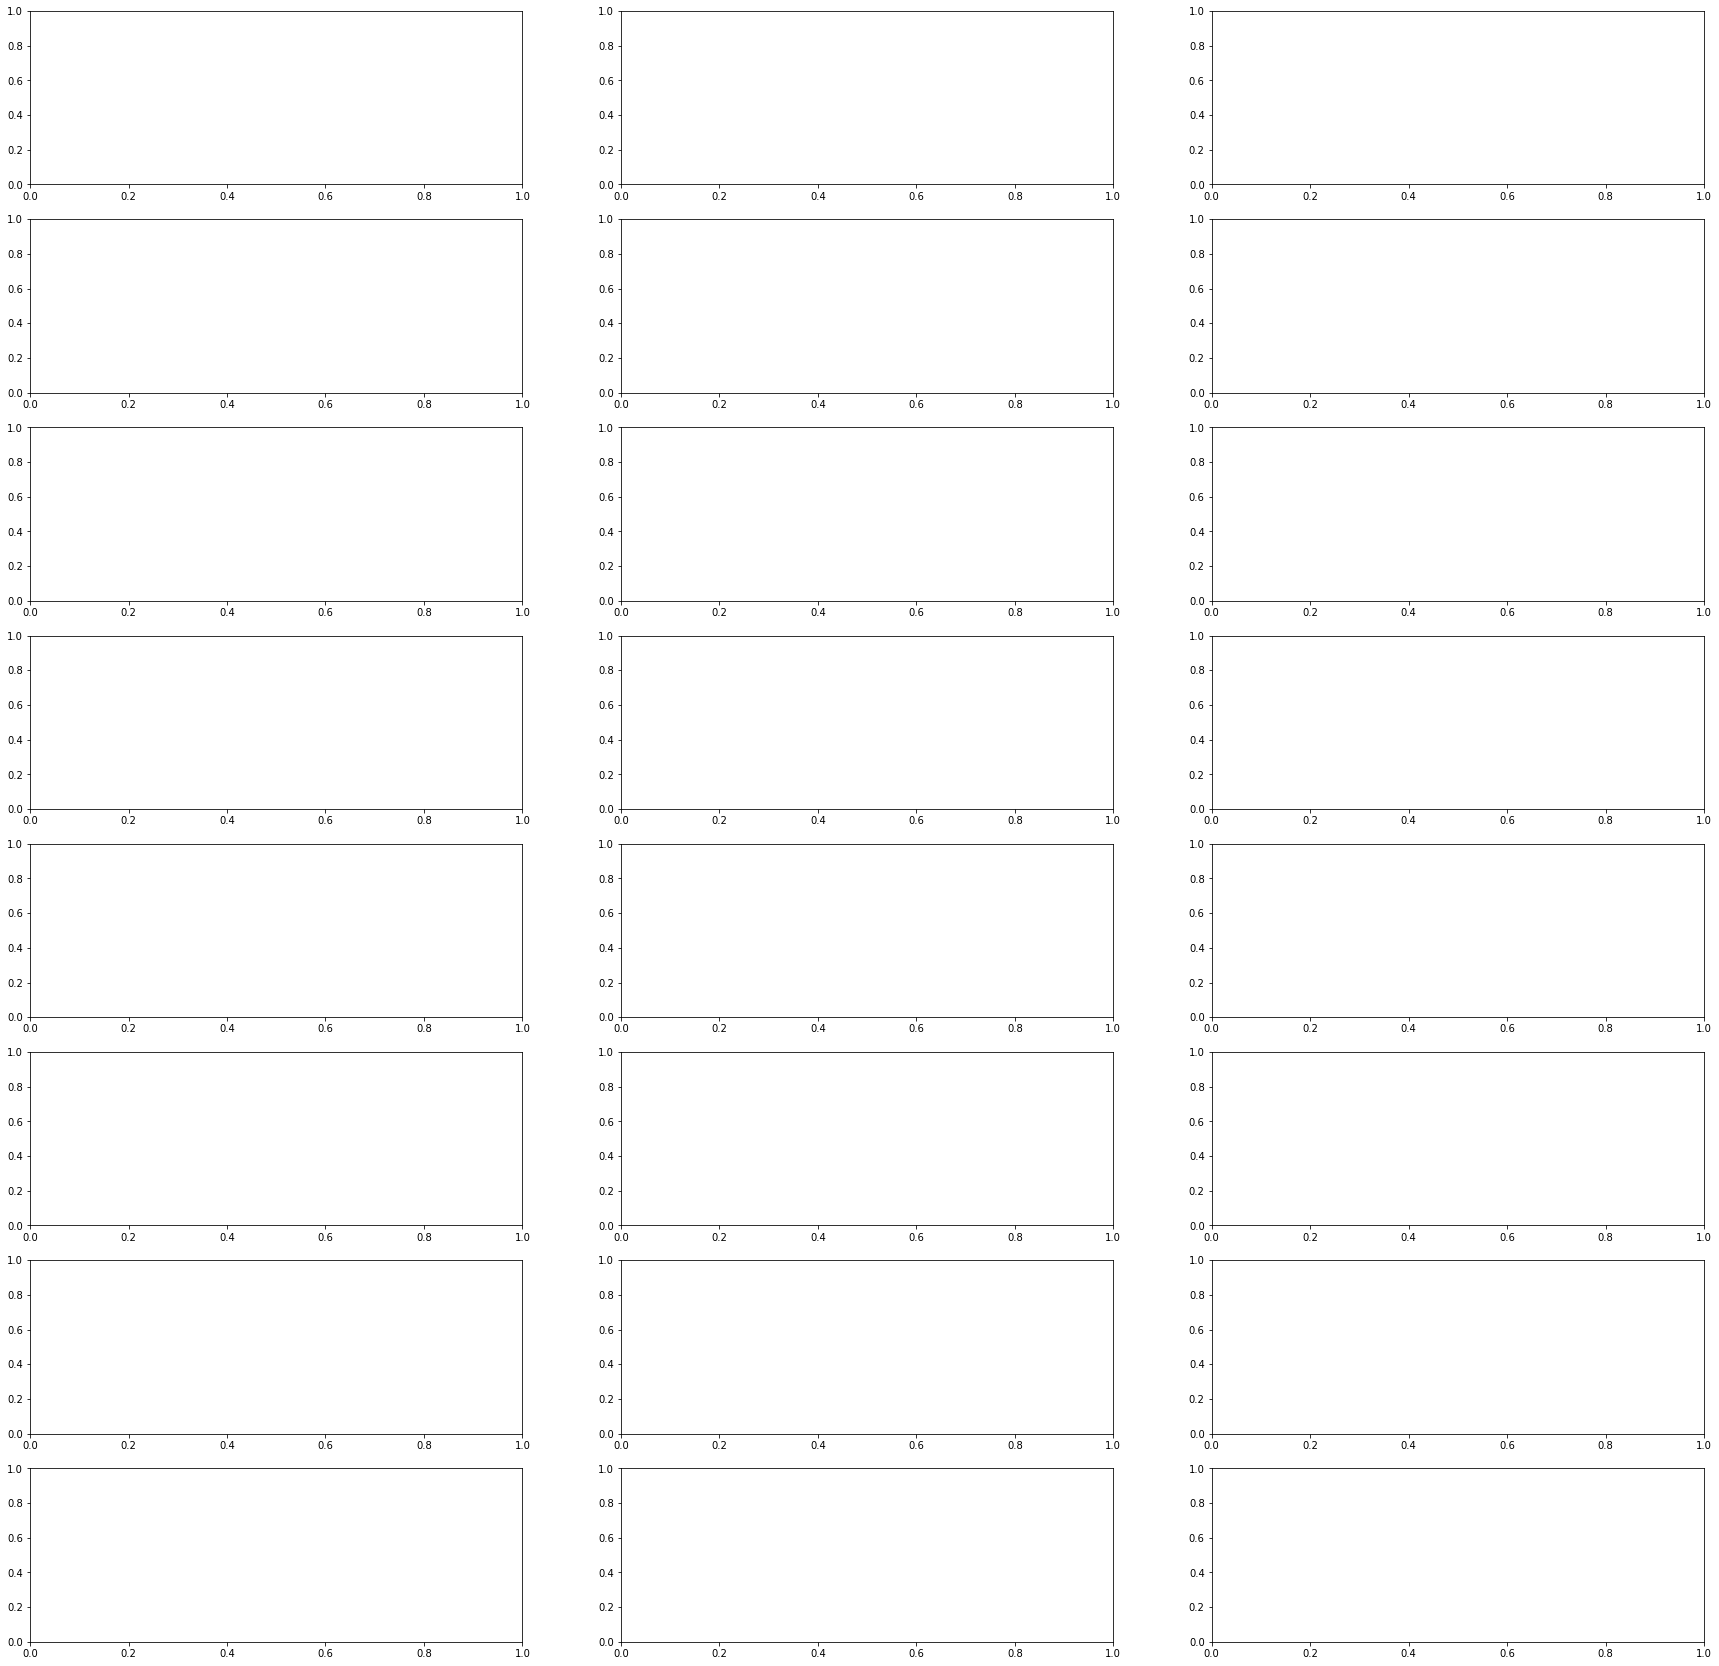

In [124]:
msoa_codes = weekly_cases_msoas.columns[1:]
fig, axs = plt.subplots(figsize =(30,30), nrows=8, ncols=3, sharey=False)
for i, ax in enumerate(fig.axes):
    msoa_code = msoa_codes[i]
    weekly = weekly_cases_msoas[['Date', msoa_code]]
    weekly_from_daily =daily_cases_msoas_weeklysums[['Date', msoa_code]]

    joined = pd.merge(weekly_from_daily, weekly, on=['Date'], how = 'outer') 
    joined.columns = ['Date', 'Weekly from daily', 'Weekly from website']   
    
    ax.plot(joined['Date'], joined['Weekly from daily'], label="Weekly (daily)", color="orange")
    ax.plot(joined['Date'], joined['Weekly from website'], label="Weekly", color="darkblue")
    #ax.set_xlabel("Date", fontsize= 16)
    #ax.set_xlabel("Date", fontsize= 16)
    ax.tick_params(axis='x', labelrotation=45 )
    ax.legend()
plt.suptitle("Comparing weekly data with weekly sums from daily data")
fig.tight_layout()
plt.show()

# Data for whole of Devon combined

Create a dataframe containing info on cases across the WHOLE of Devon, with:  
* One column with dates
* One column with the number of new cases on each date
* One column with the cumulative number of cases so far on that date

### Find total number of cases over whole of Devon

In [ ]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each day
    totals_df['Total_obs']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Find the cumulative cases
    totals_df['CumulativeCases'] = totals_df['Total_obs'].cumsum()
    # Rename column
    totals_df.rename(columns={"Total_obs": "Cases"}, inplace = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df
    
daily_cases_devon = find_devon_totals(daily_cases_msoas)   
weekly_cases_devon = find_devon_totals(weekly_cases_msoas) 
daily_cases_devon_weeklysums = find_devon_totals(daily_cases_msoas_weeklysums) 

daily_cases_devon_weeklysums.head()
daily_cases_devon_weeklysums.to_csv("daily_cases_devon_weeklysums.csv", index=False)

## Plot the number of cases over time

Using the daily case data, the daily case data summed to weekly values, and the weekly case data

Plot using a different scale on the y-axis (cases) of each plot, to compare the shape of the distribution.  
And plot using a shared scale on the y-axis (cases) of each plot, to compare the number of cases 

In [ ]:
names= ['Daily Cases', 'Weekly (from daily)', 'Weekly'] 
dfs = [daily_cases_devon, daily_cases_devon_weeklysums, weekly_cases_devon]

# shared axis
fig = plt.figure(figsize=(30,10))
for i in range(1,4):
    plt.subplot(1, 3, i)
    plt.xlabel("Date", fontsize= 16)
    plt.ylabel("Cases", fontsize= 16)
    plt.title(names[i-1])
    plt.xticks(rotation=45)
    df = dfs[i-1]
    plt.plot(df['Date'], df['Cases'], label="Shifted cases", color="blue")
fig.suptitle("Cases: individual axes", fontsize = 20)    

## Common axis  
vals = np.linspace(0,1,3)
fig, axs = plt.subplots(figsize =(30,10), nrows=1, ncols=3, sharey=True)
for i, alpha in enumerate(vals):
    df = dfs[i]
    x = df['Date']
    axs[i].plot(x, df['Cases'], label="Shifted cases", color="blue")
    axs[i].title.set_text(names[i])
    axs[i].set_xlabel("Date", fontsize= 16)
    axs[i].set_ylabel("Cases", fontsize= 16)
    axs[i].tick_params(axis='x', labelrotation=45 )
fig.suptitle("Cases: common axis", fontsize = 20)    
plt.show()

# Correcting observations - Daily case data
2 issues with recorded positive case data:
1.	There is a lag between the time of a positive test result and the time of infection
2.	Tests do not pick up all positive cases

Can correct this by:
1.	Shifting positive test results back in time (based on data on lag between infection and positive result)
2.	Using a multiplier on the number of positive cases (based on data on the proportion of positive case results being picked up by tests)


## Whole of Devon combined
### Correcting for testing lag time
Evidence indicates that COVID-19 has a 5-6 day incubation   
Meaning symptoms will start 5-6 days after infection  
To convert positive case result data into infection data need to  
move positive test results back in time by 5-6 days  

In [ ]:
def shift_cases(df, ndays):
    
#     ### Add a column containing the date, assume day 0 is first of April
#     # Define base date as 1st of April
#     base = datetime.date(year=2020, month=4, day=1)
#     # Count number of days dataframe covers
#     numdays = len(df)
#     # Create a list of this number of days starting from the base date
#     date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
#     # Convert to dataframe
#     df['Date'] = [base + datetime.timedelta(days=x) for x in range(numdays)]

    ### Shift the cases back 6 days
    # Find the index of the row which is the first values which is not 0 (first cases detected)
    for index, row in df.iterrows():
        if row['Cases'] >0:
            break
    
    # Shift the cases back by 6 days
    df_corrected = pd.DataFrame({'Date':df['Date'].iloc[:-6].reset_index(drop=True),
                            'OriginalCases': df['Cases'].iloc[:-6].reset_index(drop=True),
                            'ShiftedCases':df['Cases'].iloc[6:].reset_index(drop = True)})
    
    return (df_corrected)

# Shift whole of Devon data
daily_cases_devon_corrected= shift_cases(daily_cases_devon, 6)
daily_cases_devon_corrected

### Plot the number of cases over time for original case data and time shifted case data

In [ ]:
# Define formatting for dates
myFmt = mdates.DateFormatter('%b/%y')

# Plotting
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(myFmt)
x = range(len(daily_cases_devon_corrected))
x = daily_cases_devon_corrected['Date']
# Plot observations
ax.plot(x, daily_cases_devon_corrected['OriginalCases'], label="Original cases", color="orange")
ax.plot(x, daily_cases_devon_corrected['ShiftedCases'], label="Shifted cases", color="blue")
# Plot result from manually calibrated model
#ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

## Correcting for lack of testing: Apply multipliers
Tests do not pick up all positive cases. Therefore data on positive test results will not be a good representation of the number of actual cases in the population. An improved estimate of the number of infections in the population can be acquired through applying a multiplier to the positive cases data. Multipliers are applied to the data here based upon outputs of research by Phipps et al (2020), who applied a backcasting approach to estimate the true distribution of Covid in the population, and derived multipliers through comparison of this to the positive case data.

**NB: I just took multipliers from graph roughly, need exact figures**

Phipps, S.J., Grafton, R.Q. and Kompas, T., 2020. Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach. Royal Society open science, 7(11), p.200909.

In [ ]:
# Define multipliers (roughly taken from paper)
multipliers_dict = {'Apr2020':(100/4),'May2020': (100/5), 'Jun2020':(100/6), 'Jul2020':(100/7), 
                    'Aug2020':(100/8),'Sep2020':(100/9),'Oct2020':(100/9),
                    'Nov2020':(100/9),'Dec2020':(100/9),'Jan2021':(100/9),'Feb2021':(100/9),
                    'Mar2021':(100/9), 'Apr2021':(100/9),'May2021':(100/9)}

def apply_multipliers(df):
    # Loop through rows in cases datafrrame and check the month and year and then apply the correct multiplier
    # Save the results into a list
    df_multiplied = df.copy()
    infections= []
    for row in df.itertuples():
        month = row.Date.strftime("%b")
        year = row.Date.strftime("%Y")
        multiplier = multipliers_dict[month+year]
        infections.append(row.ShiftedCases * multiplier)

    # Add column to dataframe using the list
    df_multiplied['ShiftedInfections'] = infections
    
    return df_multiplied
daily_cases_devon_corrected['Date']
# daily_cases_devon_corrected = apply_multipliers(daily_cases_devon_corrected)
# daily_cases_devon_corrected

### Plotting
The number of cases over time for original case data, time shifted case data and time shifted infections (cases * multipliers) 

In [ ]:
#Plotting
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(myFmt)
x = range(len(daily_cases_devon_corrected))
x = daily_cases_devon_corrected['Date']
# Plot observations
ax.plot(x, daily_cases_devon_corrected['OriginalCases'], label="Original cases", color="orange")
ax.plot(x, daily_cases_devon_corrected['ShiftedCases'], label="Shifted cases", color="blue")
ax.plot(x, daily_cases_devon_corrected['ShiftedInfections'], label="Shifted infections", color="green")
# Plot result from manually calibrated model
#ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()


# Smoothing data
There is considerable noise (/outliers) in the recorded case data. To remove this, and to make patterns in the data more clear, the data can be smoothed using an algorithm.   

In this case, smoothing is achieved by fitting a generalised additive model (GAM) to the data. This is most easily implemented in R. Therefore, the corrected daily case data is saved to a csv file and smoothing is then carried out in a seperate notebook: https://github.com/Urban-Analytics/RAMP-UA/blob/Mollys_DA/experiments/calibration/observation_data/SmoothinginR.ipynb. The smoothed data is saved to a csv file and then re-uploaded into this notebook.

## Data for whole of Devon combined

#### Save the corrected daily case data to file

In [ ]:
# Save to file
daily_cases_devon_corrected.to_csv("daily_cases_devon_corrected.csv", index = False)

#### Load the smoothed daily case data from R notebook

In [ ]:
# Read smoothed data from file
gam_daily_cases_devon_corrected = pd.read_csv("gam_daily_cases_devon_corrected.csv")
gam_daily_cases_devon_corrected.columns

#### Plotting

In [ ]:
#Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
x = range(len(daily_cases_devon_corrected))
x = daily_cases_devon_corrected['Date']
# Plot observations
ax.plot(x, daily_cases_devon_corrected['OriginalCases'], label="Original cases", color="orange")
ax.plot(x, daily_cases_devon_corrected['ShiftedCases'], label="Shifted cases", color="blue")
ax.plot(x, daily_cases_devon_corrected['ShiftedInfections'], label="Shifted infections", color="green")
ax.plot(x, gam_daily_cases_devon_corrected['SmoothedShiftedInfections'], label="Shifted infections (smoothed)", color="purple")
# Plot result from manually calibrated model
#ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

# Case data - individual MSOAs

#### Shifting and multiplying case data

In [ ]:
# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_multiplied_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift cases, multiply cases and save to lists (to convert 
# later back into one dataframe with just shfited data and 
# one with just multiplied data - one column per MSOA)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = daily_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_multiplied = apply_multipliers(one_msoa_shifted)
    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    one_msoa_shifted = one_msoa_shifted.drop(['OriginalCases'], axis=1)
    # rename column for shifted, multiplied cases
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.drop(['ShiftedCases', 'OriginalCases'], axis=1)
    
    # Add to shifted dataframe list
    if not shifted_dfs:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])

    # Add to multiplied dataframe list
    if not shifted_multiplied_dfs:
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[['Date',msoa_code]])
    else:
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[[msoa_code]])   
        
# Join list of dataframes into one - shifted       
daily_cases_msoas_shiftedcases = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
daily_cases_msoas_shifted_mltpld_cases = pd.concat(shifted_multiplied_dfs, axis=1)

# Remove bottom six rows so same length as shifted data
daily_cases_msoas = daily_cases_msoas[:-6]


#### Plot for one msoa to test

In [ ]:
# plot
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(myFmt)
x = range(len(daily_cases_msoas_ts[msoa_code]))
x = daily_cases_msoas_ts['Date']
# Plot observations
ax.plot(x, daily_cases_msoas[msoa_code], label="Original cases", color="orange")
ax.plot(x, daily_cases_msoas_shiftedcases[msoa_code], label="Shifted cases", color="blue")
ax.plot(x, daily_cases_msoas_shifted_mltpld_cases[msoa_code], label="Shifted cases", color="green")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

#### Save the corrected daily case data to file

In [ ]:
# save shifted, multiplied data
daily_cases_msoas_shifted_mltpld_cases.to_csv("daily_cases_devon_msoas_corrected.csv", index= False)

#### Load the smoothed daily case data from R notebook

In [ ]:
# Read smoothed data from file
gam_daily_cases_devon_msoas_corrected = pd.read_csv("gam_daily_cases_devon_msoas_corrected.csv")

#### Plotting - one MSOA for example

In [ ]:
# plot
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(myFmt)
x = range(len(daily_cases_msoas_ts[msoa_code]))
x = daily_cases_msoas_ts['Date']
# Plot observations
ax.plot(x, daily_cases_msoas[msoa_code], label="Original cases", color="orange")
ax.plot(x, daily_cases_msoas_shiftedcases[msoa_code], label="Shifted cases", color="blue")
ax.plot(x, daily_cases_msoas_shifted_mltpld_cases[msoa_code], label="Shifted cases", color="green")
ax.plot(x, gam_daily_cases_devon_msoas_corrected[msoa_code], label="Shifted cases", color="purple")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()